In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# --- VARIÁVEIS DE CONFIGURAÇÃO DO PROJETO ARTRITE ---
# Base já imputada, antes da remoção de outliers
NOME_ARQUIVO_ENTRADA = "BaseVF.csv"
NOME_COLUNA_TARGET = 'ARTRITEC' # Ajuste o nome da sua classe alvo
# 🚨 NOVO: Nome do arquivo de saída para a base de treino sem outliers
NOME_ARQUIVO_SAIDA = "BaseSO.csv"

# 🚨 AJUSTE AQUI: Liste as colunas numéricas onde você quer aplicar o Z-Score
COLUNAS_NUMERICAS = [
    'IDADECC', 
    'PESOC', 
    'IMC', 
    'ALTURAC'
    # Adicione todas as colunas numéricas da sua base
]
LIMITE_ZSCORE = 3 # Limite: 3 desvios-padrão

def remover_outliers_zscore(df, colunas, limite):
    """
    Remove outliers das colunas listadas usando o método Z-Score.
    """
    df_limpo = df.copy()
    n_registros_originais = len(df_limpo)
    
    print("-" * 50)
    print("Iniciando a remoção de Outliers por Z-Score (> 3)")
    
    for coluna in colunas:
        if coluna in df_limpo.columns:
            media = df_limpo[coluna].mean()
            desvio_padrao = df_limpo[coluna].std()
            
            if desvio_padrao == 0:
                print(f"⚠️ Coluna '{coluna}' ignorada: Desvio padrão zero.")
                continue
                
            # Calcular o valor absoluto do Z-Score
            z_scores = np.abs((df_limpo[coluna] - media) / desvio_padrao)
            
            # Filtrar e manter apenas os registros dentro do limite
            df_limpo = df_limpo[z_scores < limite]
            print(f"✅ Coluna '{coluna}' processada. Tamanho atual: {len(df_limpo)}")
        else:
             print(f"❌ Coluna '{coluna}' não encontrada no DataFrame. Verifique a lista COLUNAS_NUMERICAS.")

    n_registros_finais = len(df_limpo)
    n_removidos = n_registros_originais - n_registros_finais
    
    print("-" * 50)
    print(f"Relatório Final de Remoção:")
    print(f"Total de registros originais do treino: {n_registros_originais}")
    print(f"Total de registros finais (limpos): {n_registros_finais}")
    print(f"Total de outliers removidos: {n_removidos}")
    print("-" * 50)
    
    return df_limpo

# --- APLICAÇÃO NO PROJETO ARTRITE ---

try:
    # 1. Carregamento e Separação Treino/Teste
    print(f"Carregando a base: {NOME_ARQUIVO_ENTRADA}")
    df = pd.read_csv(NOME_ARQUIVO_ENTRADA)
    
    X = df.drop(columns=[NOME_COLUNA_TARGET], errors='ignore')
    y = df[NOME_COLUNA_TARGET]
    
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=0.20,
        random_state=42,
        stratify=y
    )

    # 2. Combina X_treino e y_treino para aplicar a remoção
    df_treino = pd.concat([X_treino, y_treino], axis=1)

    # 3. Aplica a remoção de outliers no conjunto de TREINO
    df_treino_limpo = remover_outliers_zscore(df_treino, COLUNAS_NUMERICAS, LIMITE_ZSCORE)
    
    # 🚨 NOVO PASSO: SALVAR A BASE DE TREINO LIMPA
    df_treino_limpo.to_csv(NOME_ARQUIVO_SAIDA, index=False)
    print(f"\n✅ Base de treino sem outliers salva com sucesso em: **{NOME_ARQUIVO_SAIDA}**")

except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_ENTRADA}' não foi encontrado.")
except KeyError:
    print(f"❌ ERRO: A coluna alvo '{NOME_COLUNA_TARGET}' ou uma das colunas numéricas não foi encontrada. Verifique a lista COLUNAS_NUMERICAS.")
except Exception as e:
    print(f"❌ Ocorreu um erro: {e}")

Carregando a base: BaseVF.csv
--------------------------------------------------
Iniciando a remoção de Outliers por Z-Score (> 3)
✅ Coluna 'IDADECC' processada. Tamanho atual: 24000
✅ Coluna 'PESOC' processada. Tamanho atual: 23733
✅ Coluna 'IMC' processada. Tamanho atual: 23568
✅ Coluna 'ALTURAC' processada. Tamanho atual: 23503
--------------------------------------------------
Relatório Final de Remoção:
Total de registros originais do treino: 24000
Total de registros finais (limpos): 23503
Total de outliers removidos: 497
--------------------------------------------------

✅ Base de treino sem outliers salva com sucesso em: **BaseSO.csv**


--- Estatísticas de Remoção de Outliers ---
                Tipo de Registro  Número de Registros
0  Treino Original (Pré-limpeza)                24000
1     Treino Limpo (Pós-limpeza)                23503
2             Outliers Removidos                  497
Gráfico de barras salvo como 'grafico_remocao_outliers.png'


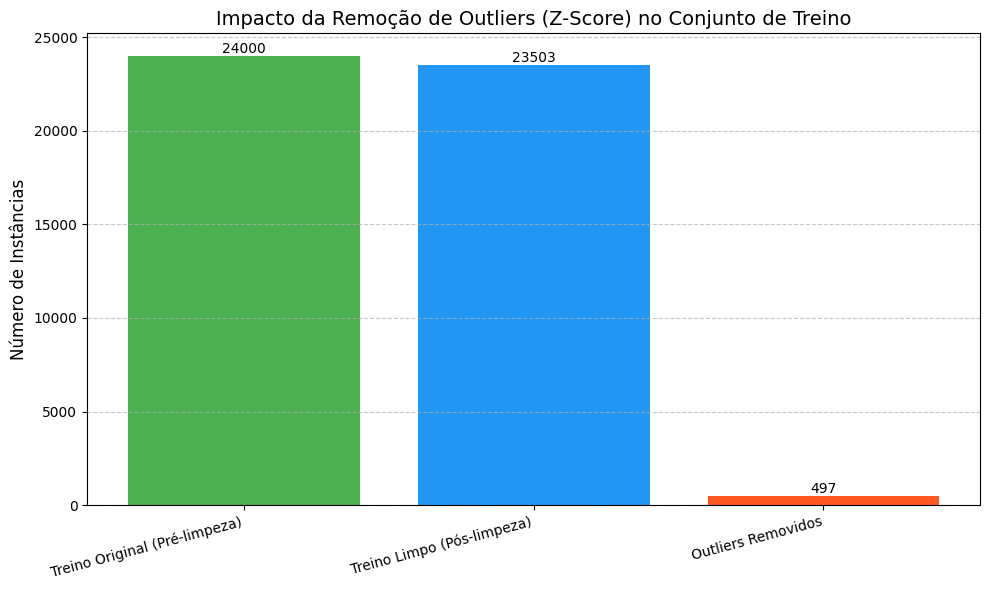

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- VARIÁVEIS DE CONFIGURAÇÃO DO PROJETO ARTRITE ---
NOME_ARQUIVO_ENTRADA = "BaseVF.csv"
NOME_ARQUIVO_SAIDA = "BaseSO.csv"
# 🚨 ATENÇÃO: Use o nome correto da sua coluna alvo
NOME_COLUNA_TARGET = 'ARTRITEC' 
# ---------------------------------------------------

try:
    # 1. Carregamento da Base Original
    df_original = pd.read_csv(NOME_ARQUIVO_ENTRADA)

    # Verifica e ajusta a coluna alvo (assumindo a última se o nome padrão falhar)
    if NOME_COLUNA_TARGET not in df_original.columns:
        NOME_COLUNA_TARGET = df_original.columns[-1]
    
    # 2. Re-divisão Treino/Teste para obter o tamanho original do treino (80%)
    X = df_original.drop(columns=[NOME_COLUNA_TARGET], errors='ignore')
    y = df_original[NOME_COLUNA_TARGET]
    
    # Recria a divisão (test_size=0.20, random_state=42)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=0.20,
        random_state=42,
        stratify=y
    )

    tamanho_original_treino = len(X_treino)

    # 3. Carregamento da Base Limpa
    df_limpo = pd.read_csv(NOME_ARQUIVO_SAIDA)
    tamanho_final_treino = len(df_limpo)
    
    # 4. Cálculo do Volume Removido
    outliers_removidos = tamanho_original_treino - tamanho_final_treino

    # 5. Preparação dos Dados para Plotagem
    dados = {
        'Tipo de Registro': ['Treino Original (Pré-limpeza)', 'Treino Limpo (Pós-limpeza)', 'Outliers Removidos'],
        'Número de Registros': [tamanho_original_treino, tamanho_final_treino, outliers_removidos]
    }
    df_plot = pd.DataFrame(dados)

    print("--- Estatísticas de Remoção de Outliers ---")
    print(df_plot)
    
    # 6. Geração do Gráfico de Barras
    cores = ['#4CAF50', '#2196F3', '#FF5722'] 

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_plot['Tipo de Registro'], df_plot['Número de Registros'], color=cores)
    
    # Adicionar rótulos de dados (valores) nas barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 10, int(yval), ha='center', va='bottom', fontsize=10)

    plt.title('Impacto da Remoção de Outliers (Z-Score) no Conjunto de Treino', fontsize=14)
    plt.ylabel('Número de Instâncias', fontsize=12)
    plt.xticks(rotation=15, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Salvar a imagem
    plt.savefig('grafico_remocao_outliers.png')
    print("Gráfico de barras salvo como 'grafico_remocao_outliers.png'")

except FileNotFoundError:
    print(f"❌ ERRO: Verifique se os arquivos '{NOME_ARQUIVO_ENTRADA}' e '{NOME_ARQUIVO_SAIDA}' estão no mesmo diretório.")
except Exception as e:
    print(f"❌ Ocorreu um erro: {e}")